In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import seaborn as sns

from utils import Pyutils as pyutils

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (15,10)

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_covdgp_data", "betadgp_beta2x2_data", "betadgp_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "ffnn", "ffnn_wmse"]
ROC_THRESHOLD = 0

## 1) Aggregate all results

In [2]:
mini_output_report = []
all_data = []
model_summary = []
class_data = []
cm_data = []
roc = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:
            
            
            try:
                check1 = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
                check2 = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            except:
                print("We coudn't find the output for " + model_tag + " " + dgp_name)
                mini_output_report.append(pd.DataFrame([{"model": model_tag, "dgp": dgp_name, "dataset": ds}]))
                continue
            
            data = check1
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            # distance metrics
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = check2
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp,
                                              index=[idx]))
            
            tmp_class_data = pd.DataFrame({"y_class": np.where(data["y"] > ROC_THRESHOLD, 1, 0),
                                           "pred_class": np.where(data["pred"] > ROC_THRESHOLD, 1, 0),
                                           "y": data["y"],
                                           "pred": data["pred"],
                                           "model": model_tag,
                                           "dgp": dgp_name,
                                           "dataset": ds})
            class_data.append(tmp_class_data)
            
            # confusion matrix            
            tmp_confusion_matrix = pd.DataFrame(confusion_matrix(tmp_class_data['y_class'],
                                                                 tmp_class_data['pred_class']))
            tmp_confusion_matrix.index.name = "Actual"
            tmp_confusion_matrix.columns.name = "Predicted"
                                          
            tmp_confusion_matrix = (tmp_confusion_matrix / tmp_confusion_matrix.sum().sum()) * 100
            melt_tmp_confusion_matrix = tmp_confusion_matrix.reset_index()
            melt_tmp_confusion_matrix = melt_tmp_confusion_matrix.melt("Actual")
            melt_tmp_confusion_matrix["model"] = model_tag
            melt_tmp_confusion_matrix["dgp"] = dgp_name
            melt_tmp_confusion_matrix["dataset"] = ds
            melt_tmp_confusion_matrix["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            
            cm_data.append(melt_tmp_confusion_matrix)
            
            tmp_roc = pyutils.roc_from_scratch(y_pred=data["pred"],
                                               y_true=np.where(data["y"] > 0, 1, 0),
                                               partitions=100)
            tmp_roc_df = pd.DataFrame(tmp_roc, columns=["TP", "FP"])
            tmp_roc_df["model"] = model_tag
            tmp_roc_df["dgp"] = dgp_name
            tmp_roc_df["dataset"] = ds
            tmp_roc_df["number_of_variables"] = int(model_summary_tmp['dgp'].split("_")[1])
            
            roc.append(tmp_roc_df)
            
            idx += 1
            
            all_data.append(data)
            
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)
class_data_df = pd.concat(class_data, axis=0)
cm_data_df = pd.concat(cm_data, axis=0).reset_index(drop=True)
roc_df = pd.concat(roc, axis=0)

Append all model results: 100%|██████████| 3/3 [00:04<00:00,  1.38s/it]


In [25]:
data["dgp"].unique()

array(['ar1_250_random'], dtype=object)

# 2) Compute relevant metrics

> a) Mean squared error

> b) Mean absolute error

> d) ROC curve

> e) Confusion matrices

In [3]:
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()

### a) MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

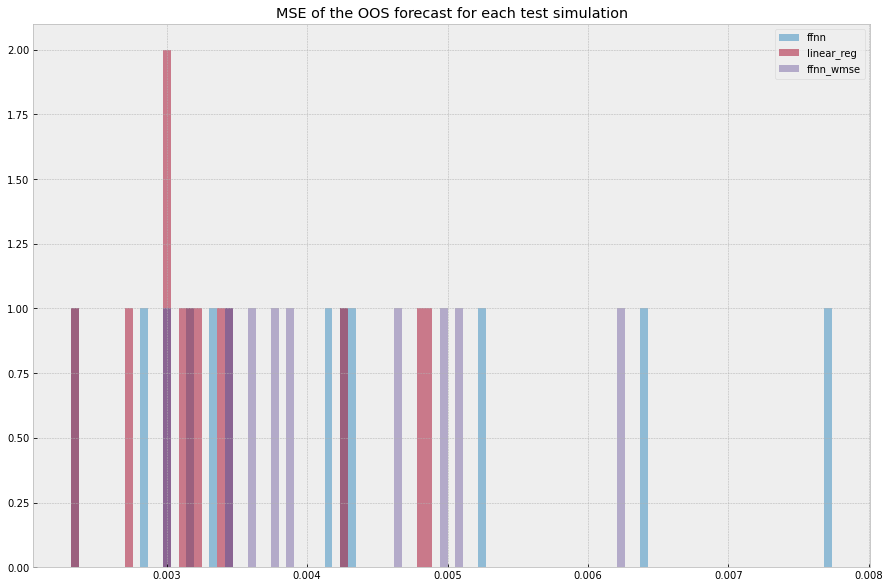

In [4]:
ffnn_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn"][["mse"]]
ffnn_hist_mse.rename(columns={"mse": "ffnn mse"}, inplace=True)

ffnn_wmse_hist_mse = mse_group_df.loc[mse_group_df["model"]=="ffnn_wmse"][["mse"]]
ffnn_wmse_hist_mse.rename(columns={"mse": "ffnn_wmse mse"}, inplace=True)

linear_reg_hist_mse = mse_group_df.loc[mse_group_df["model"]=="linear_reg"][["mse"]]
linear_reg_hist_mse.rename(columns={"mse": "linear_reg mse"}, inplace=True)

hist_mse_df = pd.concat([ffnn_hist_mse.reset_index(drop=True),
                         linear_reg_hist_mse.reset_index(drop=True),
                         ffnn_wmse_hist_mse.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mse_df.min().min(), hist_mse_df.max().max(), 100)
plt.hist(hist_mse_df[hist_mse_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mse_df[hist_mse_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.hist(hist_mse_df[hist_mse_df.columns[2]], bins, alpha=0.5, label='ffnn_wmse')
plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

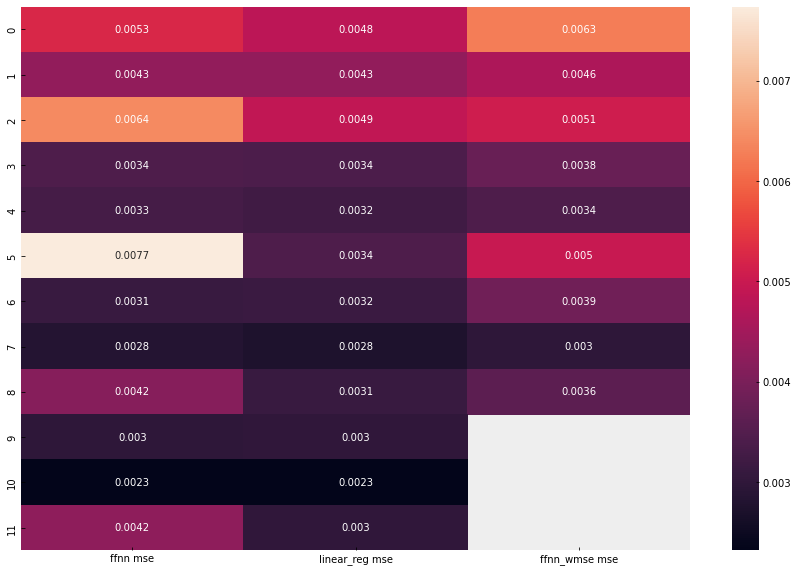

In [5]:
ax = sns.heatmap(hist_mse_df, annot=True)

### b) MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

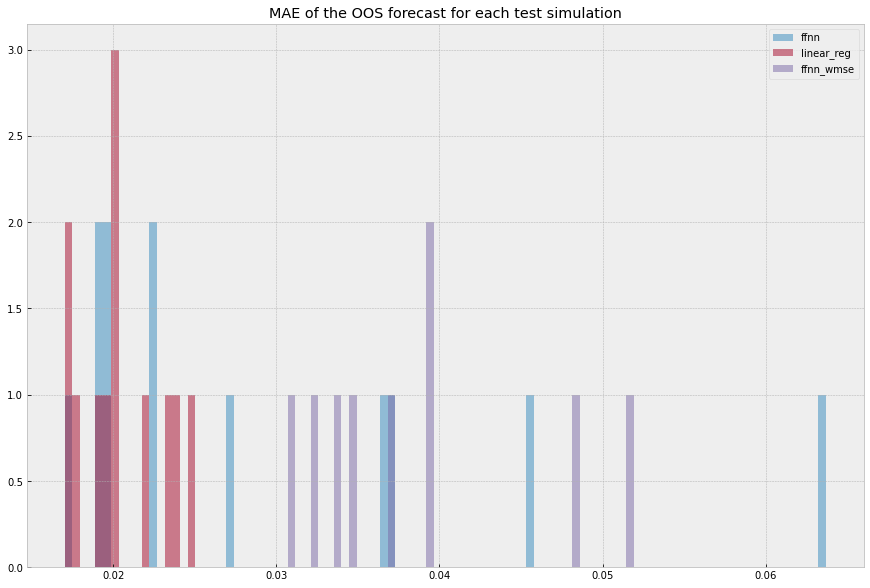

In [6]:
ffnn_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn"][["mae"]]
ffnn_hist_mae.rename(columns={"mae": "ffnn mae"}, inplace=True)

linear_reg_hist_mae = mae_group_df.loc[mae_group_df["model"]=="linear_reg"][["mae"]]
linear_reg_hist_mae.rename(columns={"mae": "linear_reg mae"}, inplace=True)

ffnn_wmse_hist_mae = mae_group_df.loc[mae_group_df["model"]=="ffnn_wmse"][["mae"]]
ffnn_wmse_hist_mae.rename(columns={"mae": "ffnn_wmse mae"}, inplace=True)

hist_mae_df = pd.concat([ffnn_hist_mae.reset_index(drop=True),
                         linear_reg_hist_mae.reset_index(drop=True),
                         ffnn_wmse_hist_mae.reset_index(drop=True)], axis=1)

bins = np.linspace(hist_mae_df.min().min(), hist_mae_df.max().max(), 100)
plt.hist(hist_mae_df[hist_mae_df.columns[0]], bins, alpha=0.5, label='ffnn')
plt.hist(hist_mae_df[hist_mae_df.columns[1]], bins, alpha=0.5, label='linear_reg')
plt.hist(hist_mae_df[hist_mae_df.columns[2]], bins, alpha=0.5, label='ffnn_wmse')
plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")

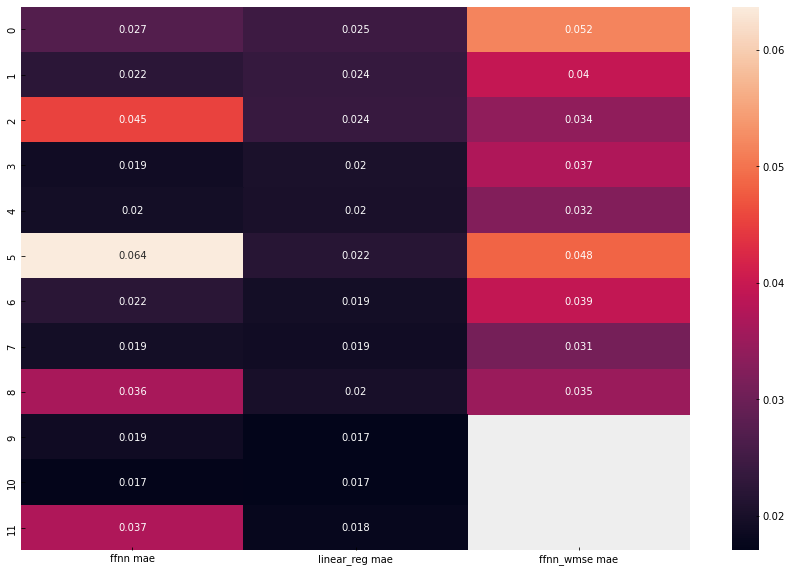

In [7]:
ax = sns.heatmap(hist_mae_df, annot=True)

### c) ROC Curve

#### SANITY

/Users/danieloliveira/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


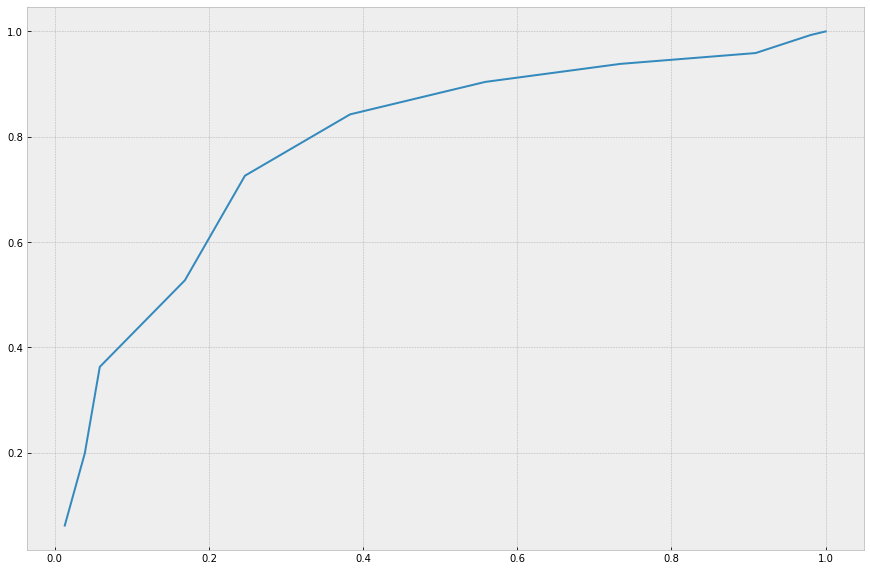

In [8]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_informative=10, n_features=20, flip_y=0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = RandomForestClassifier()
model.fit(X_train, y_train)

prob_vector = model.predict_proba(X_test)[:, 1]

sanity_roc = pyutils.roc_from_scratch(y_pred=pd.DataFrame(prob_vector),
                                      y_true=pd.DataFrame(y_test),
                                      partitions=100)
sanity_roc_df = pd.DataFrame(sanity_roc, columns=["fpr", "tpr"])

plt.plot(sanity_roc_df["tpr"],
         sanity_roc_df["fpr"])

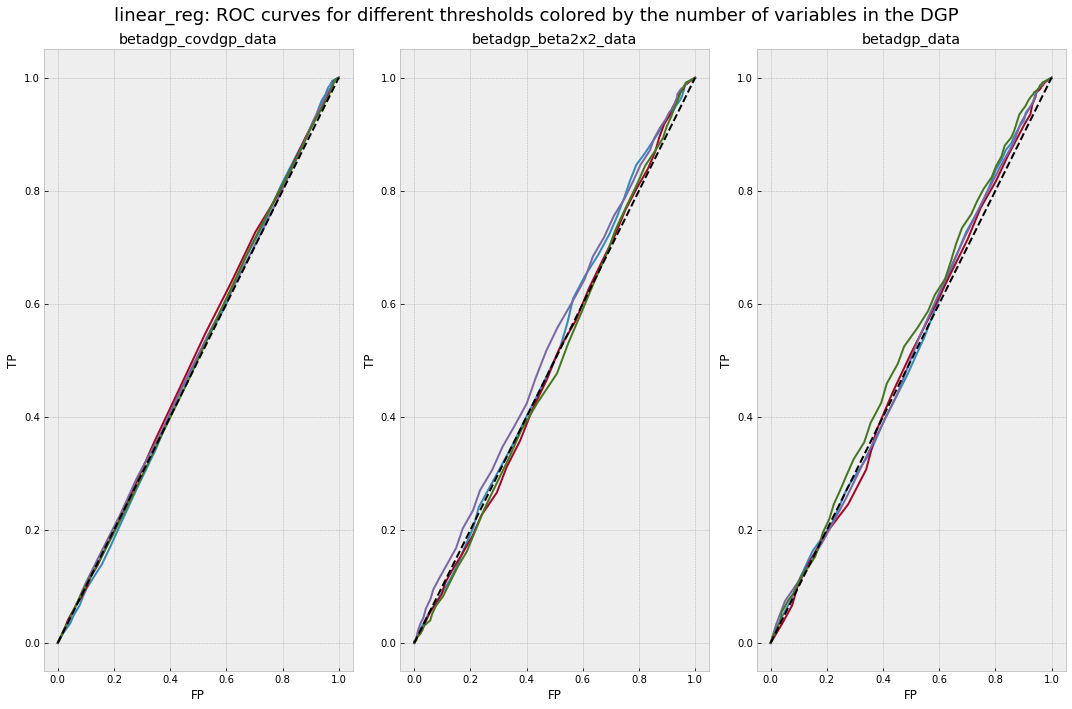

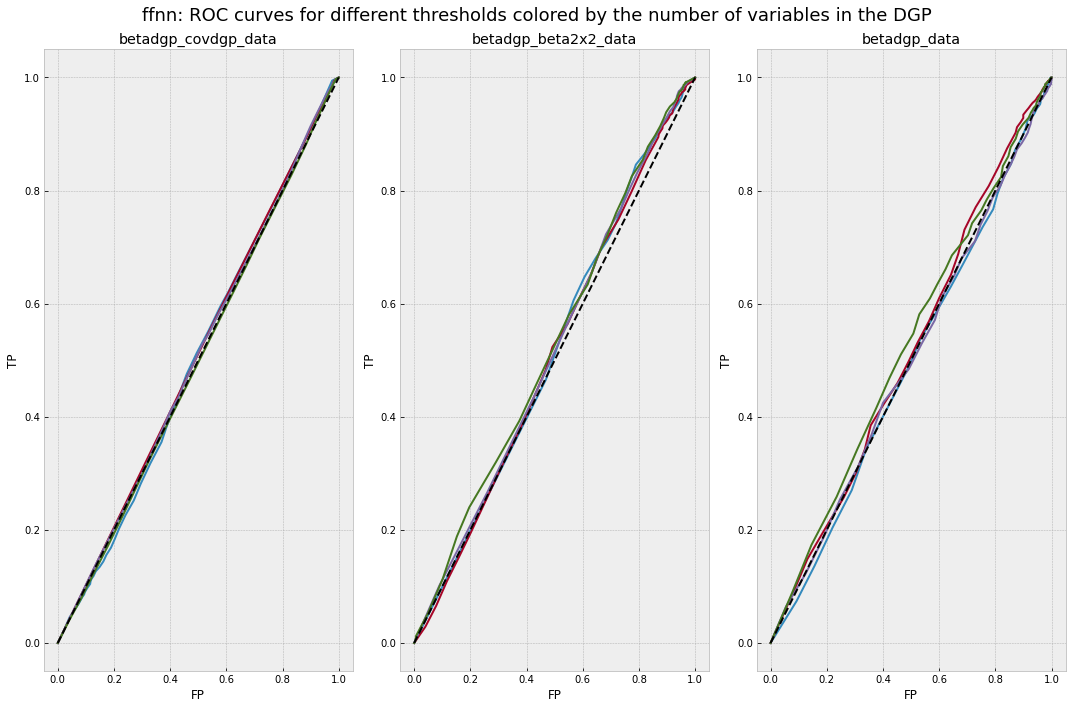

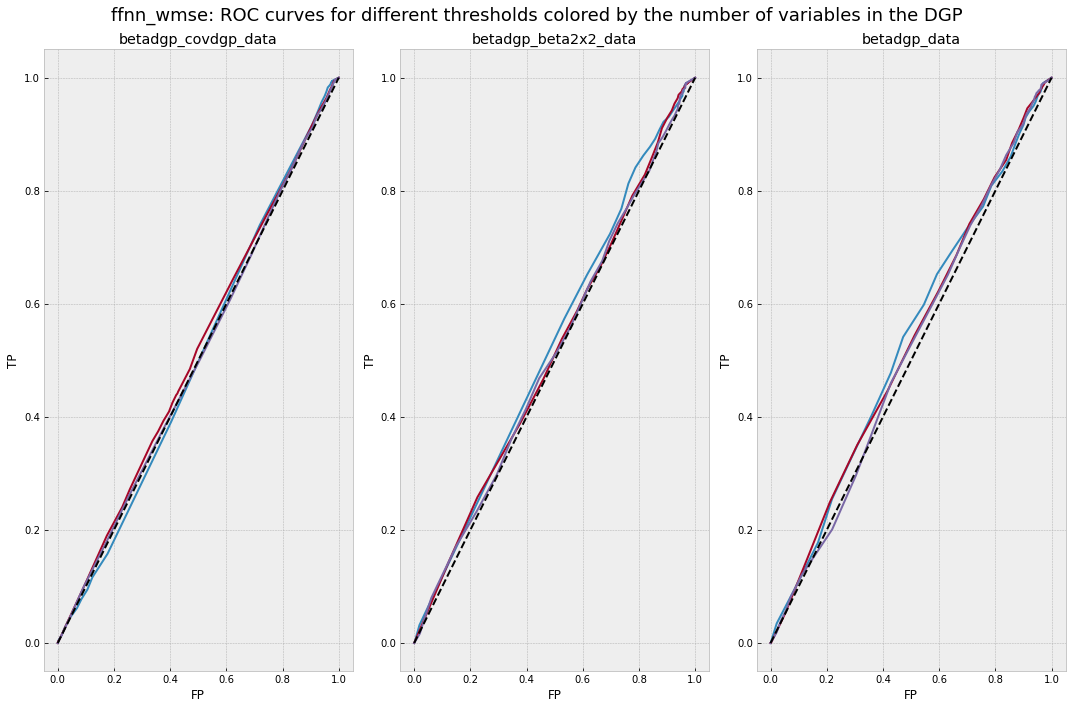

In [22]:
for i, tag in enumerate(MODEL_TAGS):
    tmp_model_df = roc_df.loc[roc_df["model"] == tag]
    
    fig, ax = plt.subplots(nrows=1, ncols=len(tmp_model_df["dataset"].unique()))
    for j, ds in enumerate(tmp_model_df["dataset"].unique()):
        groups = tmp_model_df.loc[tmp_model_df["dataset"] == ds].groupby(["number_of_variables"])

        for name, group in groups:
            ax[j].plot(group["FP"],
                       group["TP"],
                       ms=5,
                       label=name)
        ax[j].set_ylabel("TP")
        ax[j].set_xlabel("FP")
        ax[j].plot([0, 1], [0, 1], "--", color = 'black', linewidth = 2)
        ax[j].set_title(ds)
    
    fig.suptitle(tag + ": ROC curves for different thresholds colored by the number of variables in the DGP", fontsize=18)
    fig.tight_layout()